# Exploring the inclusion of jitter

This notebook explores the use of jitter for adjusting data. 

In [ ]:
# config cell
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from pyproj import Proj
from xclim import units, sdba, indices
from dask.distributed import Client

import baeda

# for reloading the baeda module which is actively developing
from importlib import reload

reload(baeda)


zarr_dir = Path("/beegfs/CMIP6/kmredilla/zarr_bias_adjust_inputs/zarr")
era5_store = Path("/beegfs/CMIP6/kmredilla/era5_3338_zarr/zarr/t2max_era5.zarr")

Spin up the dask LocalCluster for processing.

In [2]:
client = Client()

The goal of this exploration is to explore the difference between adding jitter using the `jitter_under_thresh_value` kwarg for the training step, and manually applying the jitter to the data before training, and not applying jitter at all. 

We will select a model / scenario and a single location, and run the adjustment for the three different methods. 

In [26]:
model = "GFDL-ESM4"
scenario = "ssp245"
var_id = "pr"
jitter_under_thresh = "0.01 mm d-1"

tmp_coords = baeda.get_projected_coords(
    era5_store, {"Anchorage": baeda.coords["Anchorage"]}
)

era5_var_id = baeda.era5_var_id_lu[var_id]
era5_store = zarr_dir.joinpath(f"{era5_var_id}_era5.zarr")
era5_ds = xr.open_zarr(era5_store).convert_calendar("noleap")
hist_ds = xr.open_zarr(zarr_dir.joinpath(f"{var_id}_{model}_historical.zarr"))
sim_ds = xr.open_zarr(zarr_dir.joinpath(f"{var_id}_{model}_{scenario}.zarr"))

hist_ds = baeda.drop_non_coord_vars(hist_ds)
sim_ds = baeda.drop_non_coord_vars(sim_ds)

if var_id == "pr":
    # need to set the correct compatible precipitation units for ERA5 if precip
    if era5_ds[era5_var_id].attrs["units"] == "mm":
        era5_ds[era5_var_id].attrs["units"] = "mm d-1"

hist_ds, era5_ds = baeda.ensure_matching_time_coords(hist_ds, era5_ds)

target_unit = baeda.units_lu[var_id]
# Extract time series for the location
era5_extr = units.convert_units_to(
    baeda.extract_time_series(era5_ds, era5_var_id, tmp_coords), target_unit
)
hist_extr = units.convert_units_to(
    baeda.extract_time_series(hist_ds, var_id, tmp_coords), target_unit
)
sim_extr = units.convert_units_to(
    baeda.extract_time_series(sim_ds, var_id, tmp_coords), target_unit
)


# we will do three adjustments -
# one with no jitter,
# one with the jitter applied via the kwarg,
# and one with jitter applied before manually
# first we will set up a training object with no jitter argument supplied
kind = baeda.varid_adj_kind_lu[var_id]
train_kwargs = dict(
    ref=era5_extr,
    hist=hist_extr,
    nquantiles=50,
    group="time.dayofyear",
    window=31,
    kind=kind,
    adapt_freq_thresh="1 mm d-1",
)
# these are the no-jitter objects
dqm_train = sdba.DetrendedQuantileMapping.train(**train_kwargs)
qdm_train = sdba.QuantileDeltaMapping.train(**train_kwargs)
adj_da = baeda.adjust_and_combine_dqm_qdm(dqm_train, qdm_train, sim_extr)

# now add the jitter argument, these are the jitter-kwarg objects
train_kwargs.update(jitter_under_thresh_value=jitter_under_thresh)
dqm_train_jitter = sdba.DetrendedQuantileMapping.train(**train_kwargs)
qdm_train_jitter = sdba.QuantileDeltaMapping.train(**train_kwargs)
adj_jitter_da = baeda.adjust_and_combine_dqm_qdm(
    dqm_train_jitter, qdm_train_jitter, sim_extr
)

# now manually jitter the data before adjusting
# era5_jitter = sdba.processing.jitter_under_thresh(era5_extr, thresh=jitter_under_thresh)
hist_jitter = sdba.processing.jitter_under_thresh(hist_extr, thresh=jitter_under_thresh)
# sim_jitter = sdba.processing.jitter_under_thresh(sim_extr, thresh=jitter_under_thresh)

del train_kwargs["jitter_under_thresh_value"]
# train_kwargs["ref"] = era5_jitter
train_kwargs["hist"] = hist_jitter

dqm_prejit_train = sdba.DetrendedQuantileMapping.train(**train_kwargs)
qdm_prejit_train = sdba.QuantileDeltaMapping.train(**train_kwargs)
adj_prejit_da = baeda.adjust_and_combine_dqm_qdm(
    dqm_prejit_train, qdm_prejit_train, sim_extr
)

# convert to dataframes for viz
prejitter_df = adj_prejit_da.to_dataframe()
jitter_df = adj_jitter_da.to_dataframe()
nojitter_df = adj_da.to_dataframe()
# Add jitter column to identify which jitter method was used
prejitter_df["jitter"] = "pre-jitter"
jitter_df["jitter"] = "jitter-kwarg"
nojitter_df["jitter"] = "no-jitter"

# Combine the dataframes
jitter_test_df = pd.concat([prejitter_df, jitter_df, nojitter_df])

Below are histograms of the adjusted precipitation data for precip under 2 mm/day, colored based on the jitter type and with individual plots separated by adjustment method.

This graphic shows that the three jitter methods, for this particular ESM, do not appear to give qualitatively different results. 

It also shows how shifted the low precip distribution becomes with the various detrended quantile mapping methods, though!

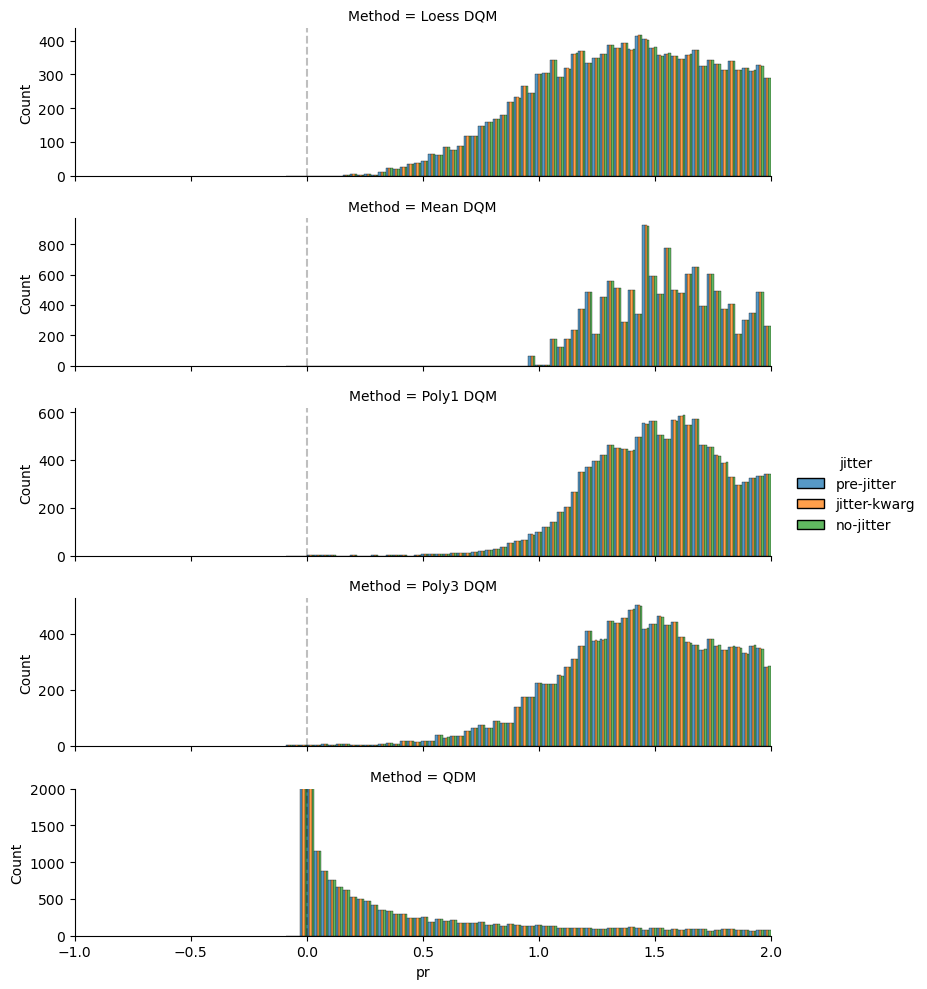

In [ ]:
g = sns.displot(
    jitter_test_df.query("pr < 2 & jitter"),
    x="pr",
    row="Method",
    hue="jitter",
    multiple="dodge",
    facet_kws=dict(sharey=False),
    height=2,
    aspect=4,
)
g.axes.flat[-1].set_ylim(0, 2000)
for ax in g.axes.flat:
    ax.set_xlim(-1, 2)
    ax.axvline(x=0, color="black", linestyle="--", alpha=0.25)

It looks like the two jitter methods result in functionally equivalent results, as further evidenced by the below histogram. Virtually all of the differences are approximately 0. This is slightly confusing, because I thought these ought to give exactly matching results.

<Axes: >

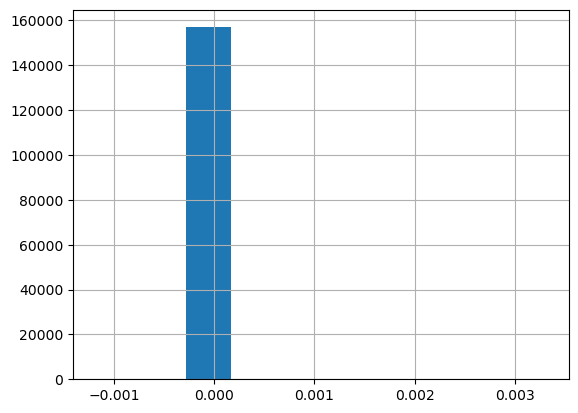

In [ ]:
(
    (
        jitter_test_df.query("jitter == 'jitter-kwarg'")["pr"]
        - jitter_test_df.query("jitter == 'pre-jitter'")["pr"]
    )
).hist()

Just expanding on the shifted distributions for the DQM methods... here is an example indicator that is impacted by these shifts. This is something that will be useful for comparing the different adjustment methods themselves!

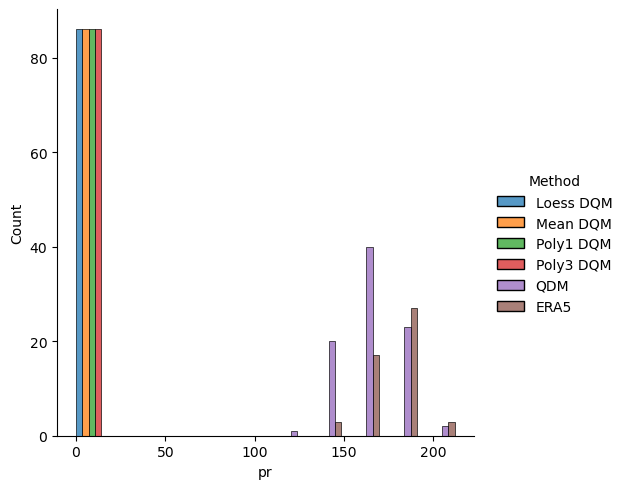

In [ ]:
tmp_df = (
    indices.dry_days(adj_jitter_da)
    .isel(location=0)
    .drop_vars("location")
    .to_dataframe()
)
era5_df = (
    indices.dry_days(era5_extr).isel(location=0).drop_vars("location").to_dataframe()
)
era5_df["Method"] = "ERA5"
era5_df = era5_df.reset_index().set_index(["Method", "time"])
tmp_df = pd.concat([tmp_df, era5_df])
g = sns.displot(
    tmp_df,
    x="pr",
    hue="Method",
    multiple="dodge",
)

In [34]:
jitter_test_df.query("jitter == 'jitter-kwarg'").shape[0]

156950

This is likely because there are not enough It results in a shifted adjusted data distribution that has much of the lower tail below zero. 

array([[<Axes: title={'center': 'pr'}>]], dtype=object)

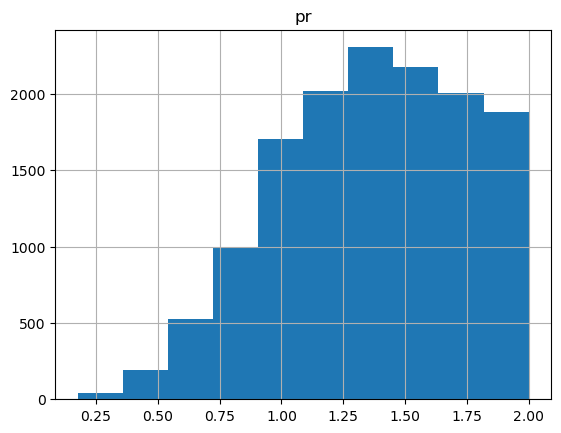

In [11]:
jitter_test_df.query("Method == 'Loess DQM' & jitter == 'jitter-kwarg' & pr < 2").hist()


Maximum values for each method and jitter type:
Method     jitter      
Loess DQM  jitter-kwarg    57.854982
           no-jitter       57.855031
           pre-jitter      57.857737
Mean DQM   jitter-kwarg    59.949754
           no-jitter       59.949782
           pre-jitter      59.951306
Poly1 DQM  jitter-kwarg    59.514205
           no-jitter       59.514237
           pre-jitter      59.516007
Poly3 DQM  jitter-kwarg    59.010111
           no-jitter       59.010148
           pre-jitter      59.012202
QDM        jitter-kwarg    62.642663
           no-jitter       62.642663
           pre-jitter      62.642663
Name: pr, dtype: float64


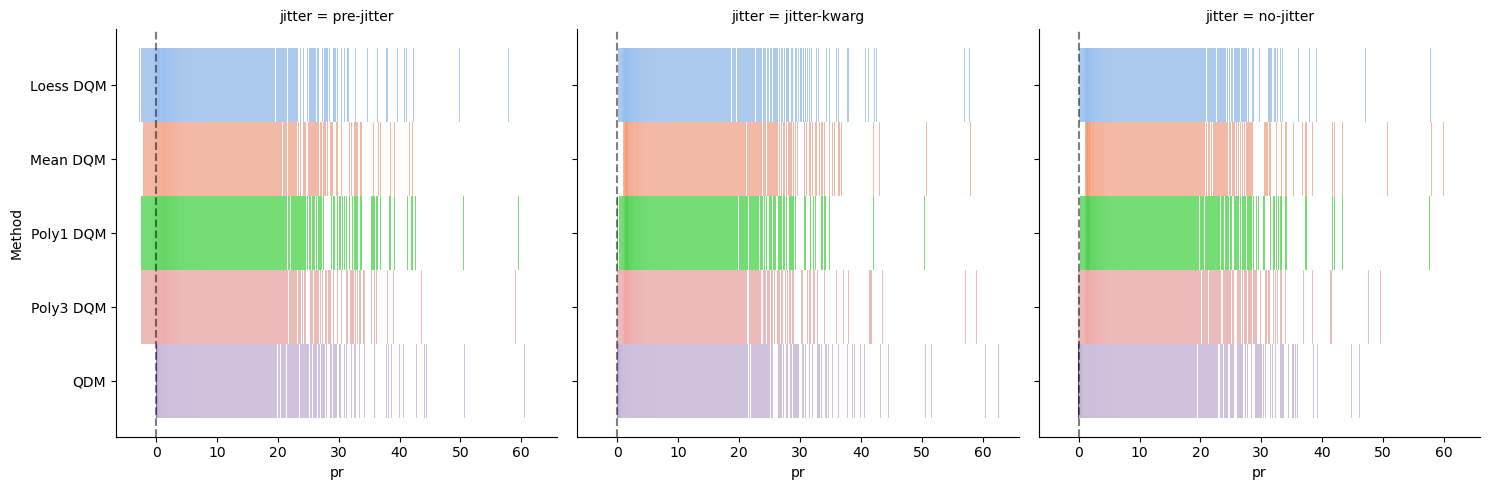

In [ ]:
model = "GFDL-ESM4"
scenario = "ssp245"
var_id = "pr"

tmp_coords = baeda.get_projected_coords(
    era5_store, {"Anchorage": baeda.coords["Anchorage"]}
)

era5_var_id = baeda.era5_var_id_lu[var_id]
era5_store = zarr_dir.joinpath(f"{era5_var_id}_era5.zarr")
era5_ds = xr.open_zarr(era5_store).convert_calendar("noleap")
hist_ds = xr.open_zarr(zarr_dir.joinpath(f"{var_id}_{model}_historical.zarr"))
sim_ds = xr.open_zarr(zarr_dir.joinpath(f"{var_id}_{model}_{scenario}.zarr"))

hist_ds = baeda.drop_non_coord_vars(hist_ds)
sim_ds = baeda.drop_non_coord_vars(sim_ds)

if var_id == "pr":
    # need to set the correct compatible precipitation units for ERA5 if precip
    if era5_ds[era5_var_id].attrs["units"] == "mm":
        era5_ds[era5_var_id].attrs["units"] = "mm d-1"

hist_ds, era5_ds = baeda.ensure_matching_time_coords(hist_ds, era5_ds)

target_unit = baeda.units_lu[var_id]
# Extract time series for the location
era5_extr = units.convert_units_to(
    baeda.extract_time_series(era5_ds, era5_var_id, tmp_coords), target_unit
)
hist_extr = units.convert_units_to(
    baeda.extract_time_series(hist_ds, var_id, tmp_coords), target_unit
)
sim_extr = units.convert_units_to(
    baeda.extract_time_series(sim_ds, var_id, tmp_coords), target_unit
)


# we will do three adjustments -
# one with no jitter,
# one with the jitter applied via the kwarg,
# and one with jitter applied before manually
# first we will set up a training object with no jitter argument supplied
kind = baeda.varid_adj_kind_lu[var_id]
train_kwargs = dict(
    ref=era5_extr,
    hist=hist_extr,
    nquantiles=50,
    group="time.dayofyear",
    window=31,
    kind=kind,
    adapt_freq_thresh="1 mm d-1",
)
# these are the no-jitter objects
dqm_train = sdba.DetrendedQuantileMapping.train(**train_kwargs)
qdm_train = sdba.QuantileDeltaMapping.train(**train_kwargs)
adj_da = baeda.adjust_and_combine_dqm_qdm(dqm_train, qdm_train, sim_extr)

# now add the jitter argument, these are the jitter-kwarg objects
jitter_under_thresh = "0.01 mm d-1"
train_kwargs.update(jitter_under_thresh_value=jitter_under_thresh)
dqm_train_jitter = sdba.DetrendedQuantileMapping.train(**train_kwargs)
qdm_train_jitter = sdba.QuantileDeltaMapping.train(**train_kwargs)
adj_jitter_da = baeda.adjust_and_combine_dqm_qdm(
    dqm_train_jitter, qdm_train_jitter, sim_extr
)

# now manually jitter the data before adjusting
era5_jitter = sdba.processing.jitter_under_thresh(era5_extr, thresh=jitter_under_thresh)
hist_jitter = sdba.processing.jitter_under_thresh(hist_extr, thresh=jitter_under_thresh)
sim_jitter = sdba.processing.jitter_under_thresh(sim_extr, thresh=jitter_under_thresh)

del train_kwargs["jitter_under_thresh_value"]
train_kwargs["ref"] = era5_jitter
train_kwargs["hist"] = hist_jitter

dqm_prejit_train = sdba.DetrendedQuantileMapping.train(**train_kwargs)
qdm_prejit_train = sdba.QuantileDeltaMapping.train(**train_kwargs)
adj_prejit_da = baeda.adjust_and_combine_dqm_qdm(
    dqm_prejit_train, qdm_prejit_train, sim_jitter
)

# convert to dataframes for viz
prejitter_df = adj_prejit_da.to_dataframe()
jitter_df = adj_jitter_da.to_dataframe()
nojitter_df = adj_da.to_dataframe()
# Add jitter column to identify which jitter method was used
prejitter_df["jitter"] = "pre-jitter"
jitter_df["jitter"] = "jitter-kwarg"
nojitter_df["jitter"] = "no-jitter"

# Combine the dataframes
jitter_test_df = pd.concat([prejitter_df, jitter_df, nojitter_df])


g = sns.displot(
    jitter_test_df, x="pr", y="Method", hue="Method", col="jitter", legend=False
)
for ax in g.axes.flat:
    ax.axvline(x=0, color="black", linestyle="--", alpha=0.5)

max_vals = jitter_test_df.groupby(["Method", "jitter"])["pr"].max()
print("\nMaximum values for each method and jitter type:")
print(max_vals)


Maximum values for each method and jitter type:
Method     jitter      
Loess DQM  jitter-kwarg    57.854974
           no-jitter       57.855031
           pre-jitter      57.857700
Mean DQM   jitter-kwarg    59.949750
           no-jitter       59.949782
           pre-jitter      59.951284
Poly1 DQM  jitter-kwarg    59.514200
           no-jitter       59.514237
           pre-jitter      59.515982
Poly3 DQM  jitter-kwarg    59.010104
           no-jitter       59.010148
           pre-jitter      59.012173
QDM        jitter-kwarg    62.642663
           no-jitter       62.642663
           pre-jitter      62.642663
Name: pr, dtype: float64


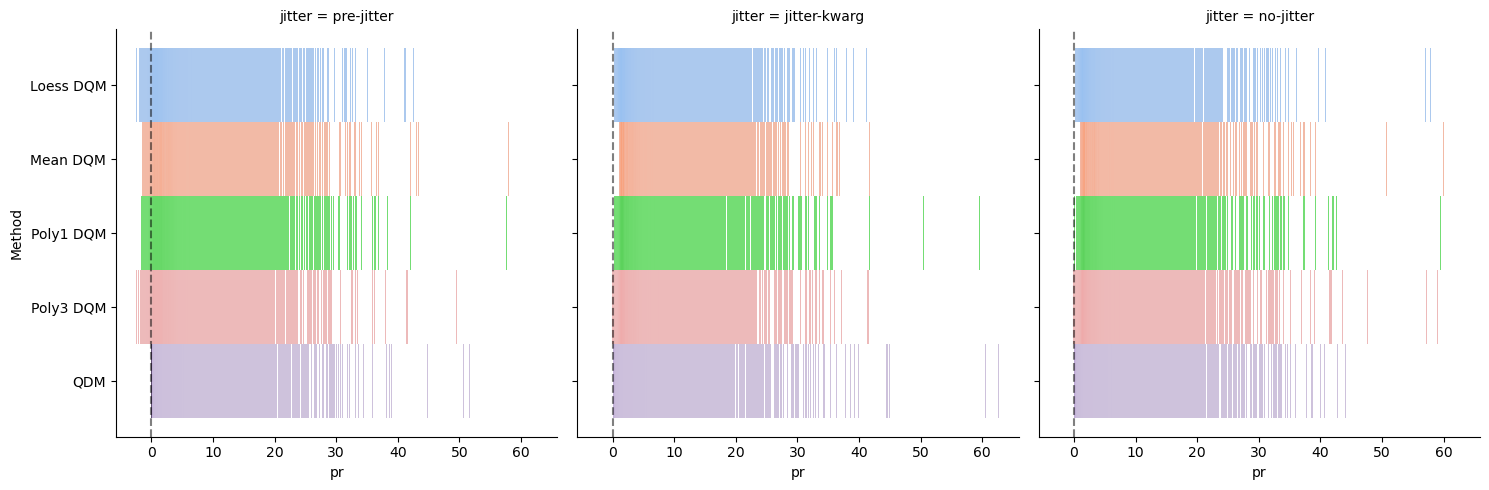

In [70]:
model = "GFDL-ESM4"
scenario = "ssp245"
var_id = "pr"

tmp_coords = baeda.get_projected_coords(
    era5_store, {"Anchorage": baeda.coords["Anchorage"]}
)

era5_var_id = baeda.era5_var_id_lu[var_id]
era5_store = zarr_dir.joinpath(f"{era5_var_id}_era5.zarr")
era5_ds = xr.open_zarr(era5_store).convert_calendar("noleap")
hist_ds = xr.open_zarr(zarr_dir.joinpath(f"{var_id}_{model}_historical.zarr"))
sim_ds = xr.open_zarr(zarr_dir.joinpath(f"{var_id}_{model}_{scenario}.zarr"))

hist_ds = baeda.drop_non_coord_vars(hist_ds)
sim_ds = baeda.drop_non_coord_vars(sim_ds)

if var_id == "pr":
    # need to set the correct compatible precipitation units for ERA5 if precip
    if era5_ds[era5_var_id].attrs["units"] == "mm":
        era5_ds[era5_var_id].attrs["units"] = "mm d-1"

hist_ds, era5_ds = baeda.ensure_matching_time_coords(hist_ds, era5_ds)

target_unit = baeda.units_lu[var_id]
# Extract time series for the location
era5_extr = units.convert_units_to(
    baeda.extract_time_series(era5_ds, era5_var_id, tmp_coords), target_unit
)
hist_extr = units.convert_units_to(
    baeda.extract_time_series(hist_ds, var_id, tmp_coords), target_unit
)
sim_extr = units.convert_units_to(
    baeda.extract_time_series(sim_ds, var_id, tmp_coords), target_unit
)


# we will do three adjustments -
# one with no jitter,
# one with the jitter applied via the kwarg,
# and one with jitter applied before manually
# first we will set up a training object with no jitter argument supplied
kind = baeda.varid_adj_kind_lu[var_id]
train_kwargs = dict(
    ref=era5_extr,
    hist=hist_extr,
    nquantiles=50,
    group="time.dayofyear",
    window=31,
    kind=kind,
    adapt_freq_thresh="1 mm d-1",
)
# these are the no-jitter objects
dqm_train = sdba.DetrendedQuantileMapping.train(**train_kwargs)
qdm_train = sdba.QuantileDeltaMapping.train(**train_kwargs)
adj_da = baeda.adjust_and_combine_dqm_qdm(dqm_train, qdm_train, sim_extr)

# now add the jitter argument, these are the jitter-kwarg objects
jitter_under_thresh = "0.01 mm d-1"
train_kwargs.update(jitter_under_thresh_value=jitter_under_thresh)
dqm_train_jitter = sdba.DetrendedQuantileMapping.train(**train_kwargs)
qdm_train_jitter = sdba.QuantileDeltaMapping.train(**train_kwargs)
adj_jitter_da = baeda.adjust_and_combine_dqm_qdm(
    dqm_train_jitter, qdm_train_jitter, sim_extr
)

# now manually jitter the data before adjusting
era5_jitter = sdba.processing.jitter_under_thresh(era5_extr, thresh=jitter_under_thresh)
hist_jitter = sdba.processing.jitter_under_thresh(hist_extr, thresh=jitter_under_thresh)
sim_jitter = sdba.processing.jitter_under_thresh(sim_extr, thresh=jitter_under_thresh)

del train_kwargs["jitter_under_thresh_value"]
train_kwargs["ref"] = era5_jitter
train_kwargs["hist"] = hist_jitter

dqm_prejit_train = sdba.DetrendedQuantileMapping.train(**train_kwargs)
qdm_prejit_train = sdba.QuantileDeltaMapping.train(**train_kwargs)
adj_prejit_da = baeda.adjust_and_combine_dqm_qdm(
    dqm_prejit_train, qdm_prejit_train, sim_jitter
)

# convert to dataframes for viz
prejitter_df = adj_prejit_da.to_dataframe()
jitter_df = adj_jitter_da.to_dataframe()
nojitter_df = adj_da.to_dataframe()
# Add jitter column to identify which jitter method was used
prejitter_df["jitter"] = "pre-jitter"
jitter_df["jitter"] = "jitter-kwarg"
nojitter_df["jitter"] = "no-jitter"

# Combine the dataframes
jitter_test_df = pd.concat([prejitter_df, jitter_df, nojitter_df])


g = sns.displot(
    jitter_test_df, x="pr", row="Method", hue="Method", col="jitter", legend=False
)
for ax in g.axes.flat:
    ax.axvline(x=0, color="black", linestyle="--", alpha=0.5)
# Get max values for each method and jitter combination
max_vals = jitter_test_df.groupby(["Method", "jitter"])["pr"].max()
print("\nMaximum values for each method and jitter type:")
print(max_vals)

Okay, so seaborn threw me for a loop here! 
I was confused by comparison across jitter strategies for some of the adjustment methods. Paying particular attention to the maximum values shown by the lines, I was struck by the differences between jitter types. Here is QDM, for example: 

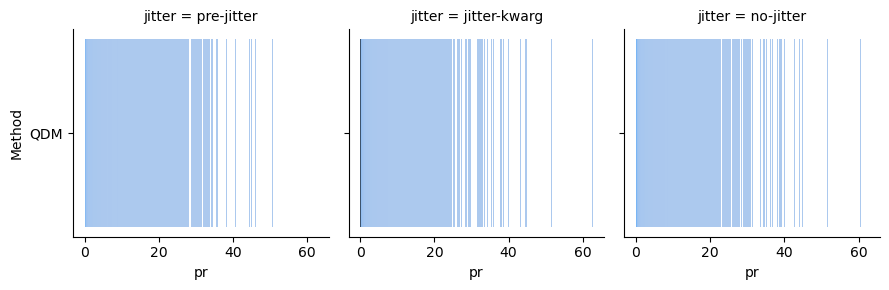

In [ ]:
g = sns.displot(
    jitter_test_df.query("Method == 'QDM'"),
    x="pr",
    y="Method",
    hue="Method",
    col="jitter",
    legend=False,
    height=3,
)

It would seem that the maximum adjusted value of the `pre-jitter` type is somehwhere around 50 mm, however that is simply not the case. This shows that each jitter type results in the same maximum adjusted value:

In [104]:
max_vals = jitter_test_df.query("Method == 'QDM'").groupby(["jitter"])["pr"].max()
print("\nMaximum values for each jitter type:")
print(max_vals)


Maximum values for each jitter type:
jitter
jitter-kwarg    62.642663
no-jitter       62.642663
pre-jitter      62.642663
Name: pr, dtype: float64


So something is inconsistent with how seaborn shows the "lines" of the histogram. I think it has something to do with specifying `y='Method'`. Omitting it shows something more expected. 

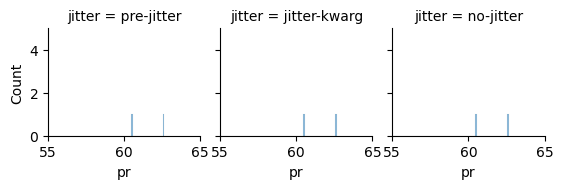

In [109]:
g = sns.displot(
    jitter_test_df.query("Method == 'QDM'"),
    x="pr",
    hue="Method",
    col="jitter",
    legend=False,
    height=2,
)
for ax in g.axes.flat:
    ax.set_xlim(55, 65)
    ax.set_ylim(0, 5)

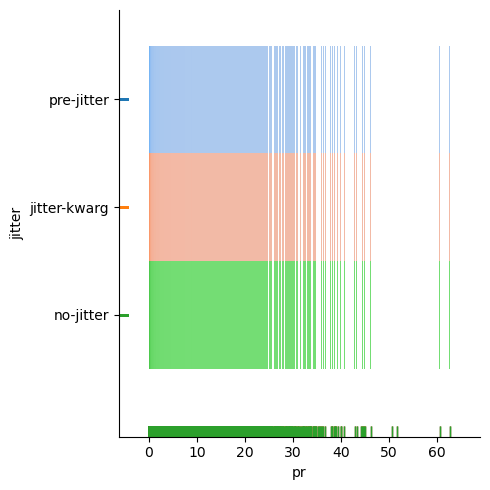

In [74]:
sns.displot(
    jitter_test_df.query("Method == 'QDM'"),
    x="pr",
    y="jitter",
    hue="jitter",
    legend=False,
)

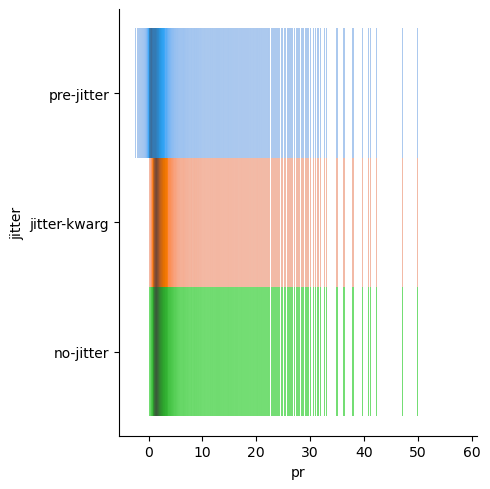

In [73]:
sns.displot(
    jitter_test_df,
    x="pr",
    y="jitter",
    hue="jitter",
    legend=False,
)


Maximum values for each method and jitter type:
Method     jitter      
Loess DQM  jitter-kwarg    57.854974
           no-jitter       57.855031
           pre-jitter      57.857700
Mean DQM   jitter-kwarg    59.949750
           no-jitter       59.949782
           pre-jitter      59.951284
Poly1 DQM  jitter-kwarg    59.514200
           no-jitter       59.514237
           pre-jitter      59.515982
Poly3 DQM  jitter-kwarg    59.010104
           no-jitter       59.010148
           pre-jitter      59.012173
QDM        jitter-kwarg    62.642663
           no-jitter       62.642663
           pre-jitter      62.642663
Name: pr, dtype: float64


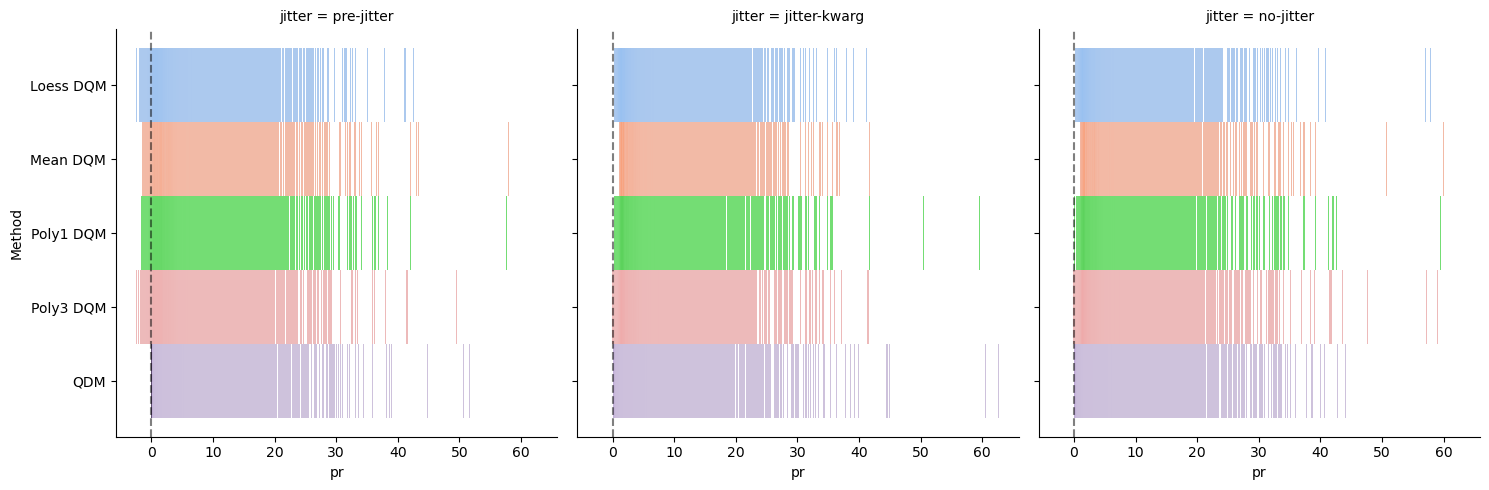

In [76]:
g = sns.displot(
    jitter_test_df, x="pr", y="Method", hue="Method", col="jitter", legend=False
)
for ax in g.axes.flat:
    ax.axvline(x=0, color="black", linestyle="--", alpha=0.5)
# Get max values for each method and jitter combination
max_vals = jitter_test_df.groupby(["Method", "jitter"])["pr"].max()
print("\nMaximum values for each method and jitter type:")
print(max_vals)

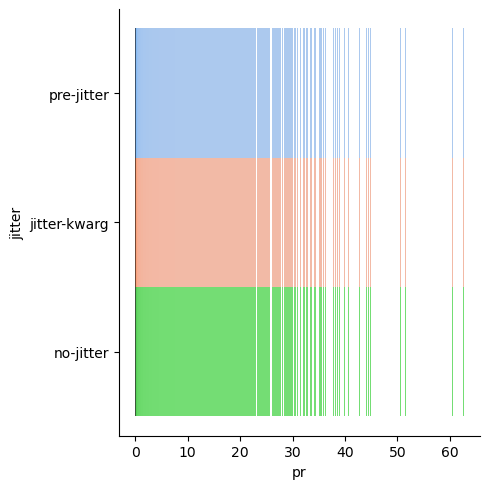

In [ ]:
sns.displot(
    jitter_test_df.query("Method == 'QDM'"),
    x="pr",
    y="jitter",
    hue="jitter",
    legend=False,
)

In [90]:
subset

Index(['Loess DQM', 'Loess DQM', 'Loess DQM', 'Loess DQM', 'Loess DQM',
       'Loess DQM', 'Loess DQM', 'Loess DQM', 'Loess DQM', 'Loess DQM',
       ...
       'QDM', 'QDM', 'QDM', 'QDM', 'QDM', 'QDM', 'QDM', 'QDM', 'QDM', 'QDM'],
      dtype='object', name='Method', length=156950)

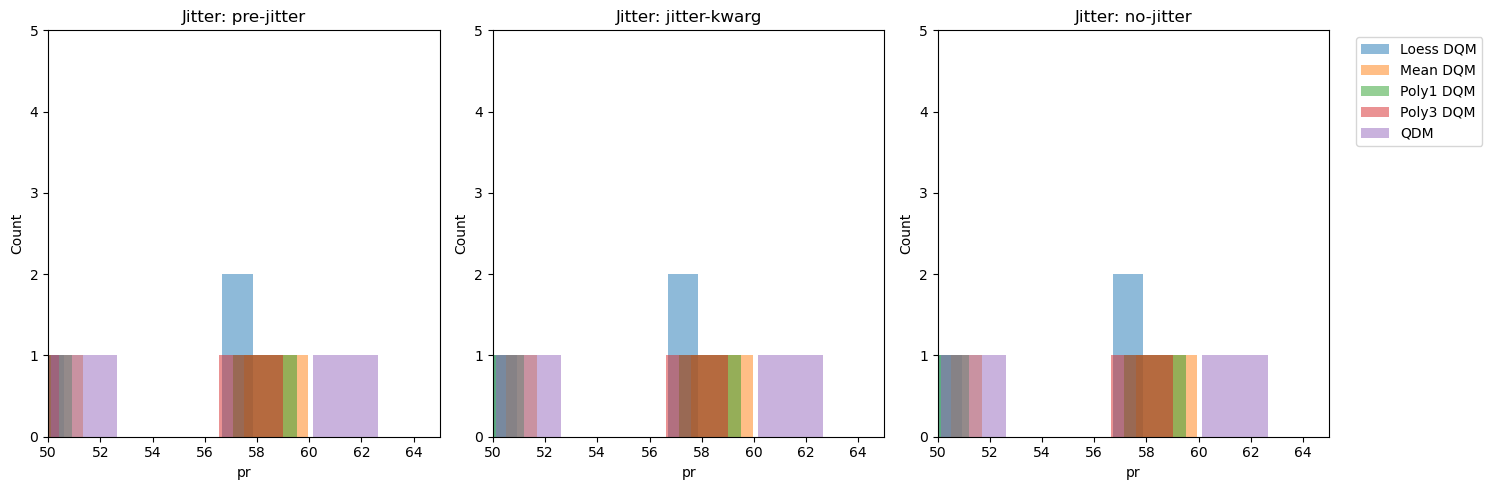

In [ ]:
# Get unique jitter values
jitter_types = jitter_test_df["jitter"].unique()

# Create subplot for each jitter type
fig, axes = plt.subplots(1, len(jitter_types), figsize=(15, 5))

# Plot histogram for each jitter type
for ax, jitter in zip(axes, jitter_types):
    # Get data for this jitter type
    subset = jitter_test_df[jitter_test_df["jitter"] == jitter].reset_index()

    # Plot histogram for each method
    for method in subset["Method"].unique():
        method_data = subset[subset["Method"] == method]["pr"]
        ax.hist(method_data, bins=50, alpha=0.5, label=method)

    ax.axvline(x=0, color="black", linestyle="--", alpha=0.5)
    ax.set_title(f"Jitter: {jitter}")
    ax.set_xlabel("pr")
    ax.set_ylabel("Count")
    ax.set_ylim(0, 5)
    ax.set_xlim(50, 65)

# Add legend to the rightmost subplot
axes[-1].legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()

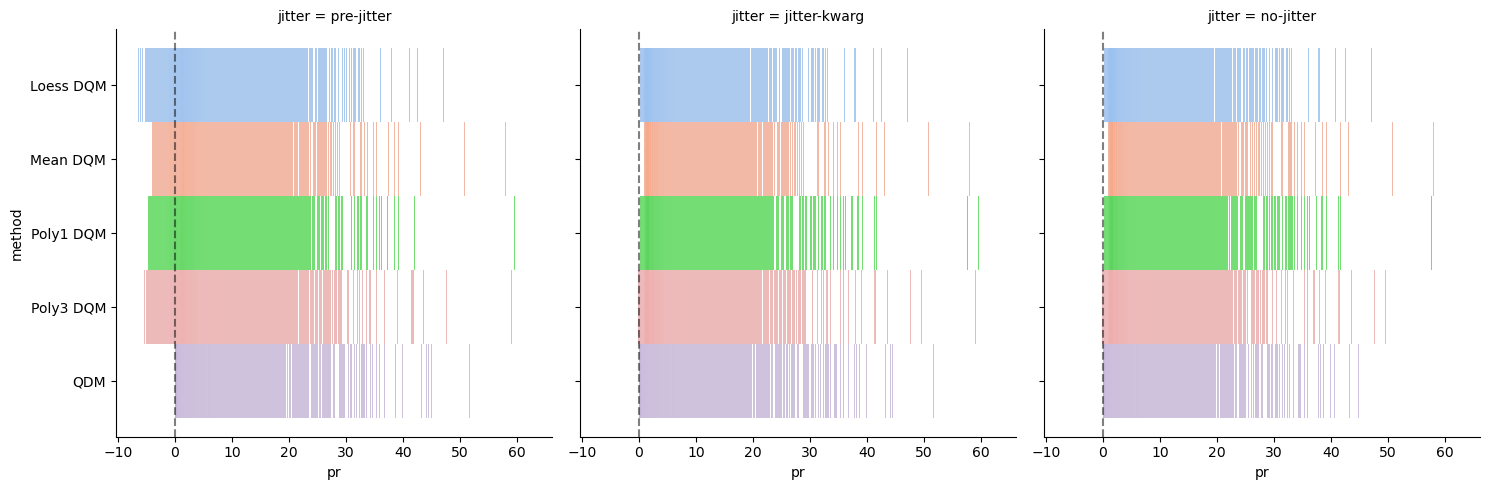

In [ ]:
g = sns.displot(
    jitter_test_df, x="pr", y="method", hue="method", col="jitter", legend=False
)
for ax in g.axes.flat:
    ax.axvline(x=0, color="black", linestyle="--", alpha=0.5)

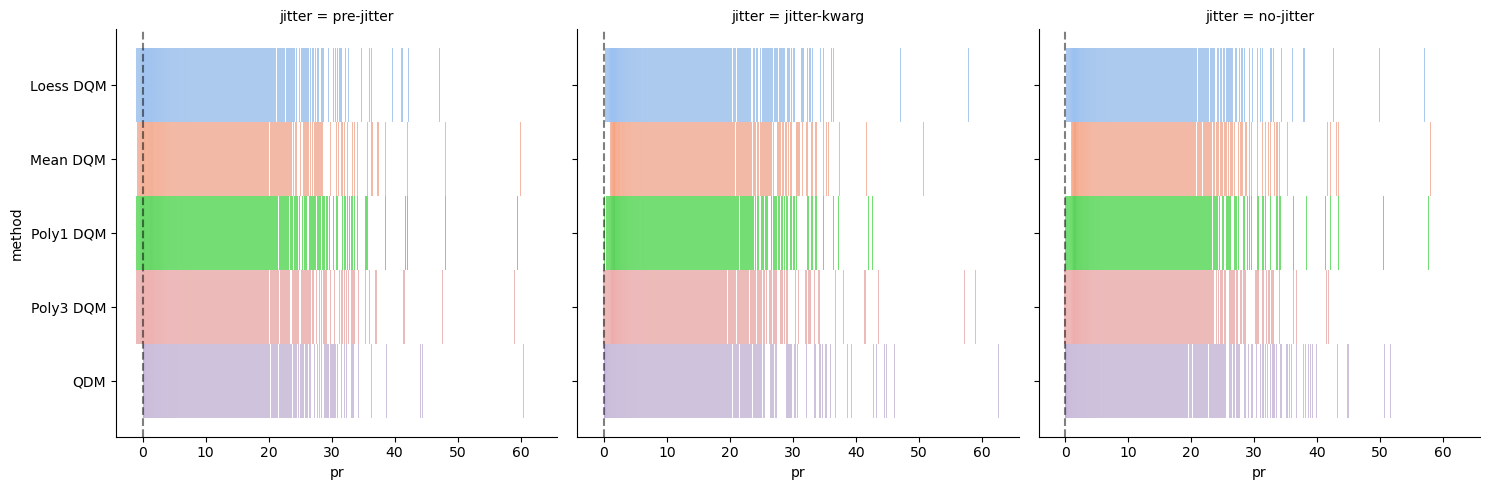

In [ ]:
g = sns.displot(
    jitter_test_df, x="pr", y="method", hue="method", col="jitter", legend=False
)
for ax in g.axes.flat:
    ax.axvline(x=0, color="black", linestyle="--", alpha=0.5)

I think this illustrates why there is not much difference between the jitter methods. Althou

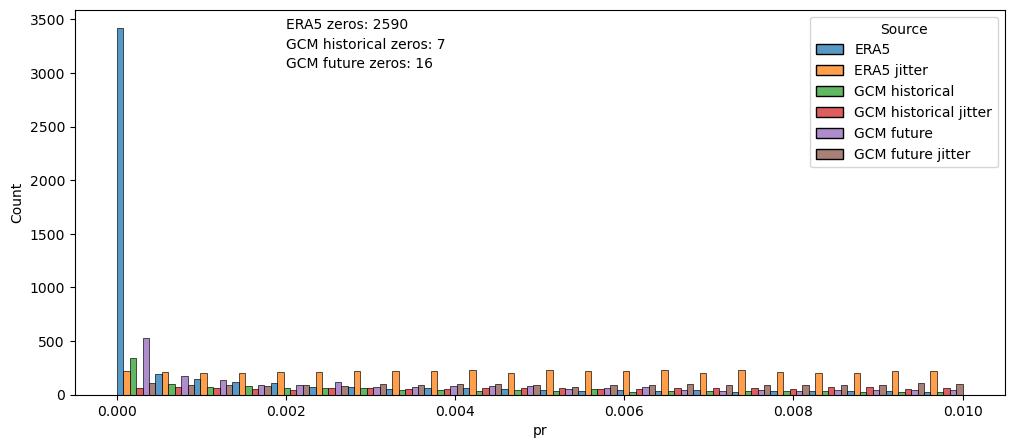

In [ ]:
# Create dataframes for each dataset and add identifying columns
# era5_df = era5_extr.to_dataframe()
# era5_df['Source'] = 'ERA5'
# era5_jit_df = era5_jitter.to_dataframe()
# era5_jit_df['Source'] = 'ERA5 jitter'
# hist_df = hist_extr.to_dataframe()
# hist_df['Source'] = 'GCM historical'
# hist_jit_df = hist_jitter.to_dataframe()
# hist_jit_df['Source'] = 'GCM historical jitter'
# sim_df = sim_extr.to_dataframe()
# sim_df['Source'] = 'GCM future'
# sim_jit_df = sim_jitter.to_dataframe()
# sim_jit_df['Source'] = 'GCM future jitter'

# all_data_df = pd.concat([
#     era5_df, era5_jit_df,
#     hist_df, hist_jit_df,
#     sim_df, sim_jit_df
# ])

fig, ax = plt.subplots(figsize=(12, 5))

sns.histplot(
    data=all_data_df.query("pr < 0.01"),
    x="pr",
    hue="Source",
    multiple="dodge",
    ax=ax,
)


# Calculate number of zeros for each source
zero_counts = {
    "ERA5": len(era5_df.query("pr == 0")),
    "GCM historical": len(hist_df.query("pr == 0")),
    "GCM future": len(sim_df.query("pr == 0")),
}

# Add text annotations for zero counts
y_pos = ax.get_ylim()[1]
x_pos = 0.002
for i, (source, count) in enumerate(zero_counts.items()):
    ax.text(x_pos, y_pos * (0.95 - i * 0.05), f"{source} zeros: {count}", fontsize=10)

In [ ]:
# Compute quantiles on ERA5 data
era5_df["pr"].quantile(np.linspace(0, 1, 50)).min()

0.0

In [ ]:
minq_doy = dqm_train.ds.hist_q.isel(quantiles=0).argmin("dayofyear").values[0]
minq_doy_af = dqm_train.ds.af.isel(quantiles=0).isel(dayofyear=minq_doy).values

print(
    "GCM historical smallest quantile value: ",
    dqm_train.ds.hist_q.isel(quantiles=0).min().values,
)
print("Corresponding adjustment factor: ", minq_doy_af)

GCM historical smallest quantile value:  1.4353364071182419e-08
Corresponding adjustment factor:  [0.]


In [ ]:
print(
    "GCM historical smallest quantile value: ",
    dqm_train.ds.hist_q.isel(quantiles=0).min().values,
)
print(
    "Corresponding adjustment factor: ", dqm_train.ds.af.isel(quantiles=0).min().values
)

array(1.43533641e-08)